In [1]:
#import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point,Polygon
from scipy.io import loadmat
from scipy.io import savemat
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
import re
import matplotlib.patches as mpatch
import itertools
import seaborn as sns
from scipy.optimize import curve_fit
from matplotlib import patches
from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches
import netCDF4
import matplotlib.image as mpimg
import pandas as pd
from scipy import stats
names = globals()

In [2]:

xtick_font = {
    "family": "DejaVu Sans",
    "size": 10,
    "weight": "bold",
    "alpha": 1.0,
    "zorder": 3,
}

color="#003366"
edgecolor="k"
linewidth=0.5
alpha=0.7

In [3]:
def cal_gammaProfile(cccc): # Skewness
    maxRow = np.zeros([cccc.shape[0]])
    # the idea is to pick up all continuous (x>=2) empty space, document their index, and evaluate the "alignness" of this building array  
    for x in range(cccc.shape[0]):
        tmp = cccc[x,:]
        names['slice'+str(x)] = []
        if tmp.any()!=0: # In case encountered a zero array
            cc = np.where(tmp==0)[0]
            cc0 = cc[0]
            first = True
            for i in range(cc.size):
                try:
                    if (cc[i]+1)!=(cc[i+1]):
                        cc1 = cc[i]
                        names['slice'+str(x)].append(np.linspace(cc0,cc1,cc1-cc0+1,dtype='int'))
                        if (cc1-cc0+1)>maxRow[x]:
                            maxRow[x] = cc1-cc0+1
                            if first:
                                tmp1 = cc1-cc0+1
                                first = False
                        cc0 = cc[i+1]
                        
                except:
                    tmp = cc[-1] - cc0 + 1 + tmp1
                    if tmp > maxRow[x]:
                        maxRow[x] = tmp
        else:
            maxRow[x] = cccc.shape[1]
    
    alignness = np.round(np.mean(maxRow)/cccc.shape[1],4)
    return(maxRow[::-1])



def cal_lp(topo):
    t = 0
    for i in range(topo.shape[0]):
        for j in range(topo.shape[1]):
            if topo[i,j] != 0:
                t+=1
    return(t/topo.size)


def cal_WGSdist(Gx1,Gx2,Gy1,Gy2): # Calculate real distance of two points with longitude and latitude
    R = 6371 
    x1 = Gx1
    x2 = Gx2
    y1 = Gy1
    y2 = Gy2
    dLon = np.deg2rad(x2-x1)
    dLat = np.deg2rad(y2-y1)

    a = np.sin(dLat/2)**2 + np.cos(np.deg2rad(y1))*np.cos(np.deg2rad(y2))*np.sin(dLon/2)**2
    
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    dist = R*c*1000 # distance in m
    return(dist)

def cal_alignness(cccc):
    maxRow = np.zeros([cccc.shape[0]])
    
    # the idea is to pick up all continuous (x>=2) empty space, document their index, and evaluate the "alignness" of this building array  
    for x in range(cccc.shape[0]):
        tmp = cccc[x,:]
        names['slice'+str(x)] = []
        if tmp.any()!=0: # In case encountered a zero array
            cc = np.where(tmp==0)[0]
            cc0 = cc[0]
            first = True
            for i in range(cc.size):
                try:
                    if (cc[i]+1)!=(cc[i+1]):
                        cc1 = cc[i]
                        names['slice'+str(x)].append(np.linspace(cc0,cc1,cc1-cc0+1,dtype='int'))
                        if (cc1-cc0+1)>maxRow[x]:
                            maxRow[x] = cc1-cc0+1
                            if first:
                                tmp1 = cc1-cc0+1
                                first = False
                        cc0 = cc[i+1]
                        
                except:
                    tmp = cc[-1] - cc0 + 1 + tmp1
                    if tmp > maxRow[x]:
                        maxRow[x] = tmp
        else:
            maxRow[x] = cccc.shape[1]
    alignness = np.round(np.mean(maxRow)/cccc.shape[1],4)
    return(alignness)


def centroid(vertexes):
    x_list = [vertex [0] for vertex in vertexes]
    y_list = [vertex [1] for vertex in vertexes]
    len = len(vertexes)
    x = sum(x_list)/_len
    y = sum(y_list)/_len
    
    return(x, y)

def cal_lf(cccc,dxdy):
    tt = 0
    for x in range(cccc.shape[0]):
        tmp = cccc[x,:]
        if tmp.any()!=0: # In case encountered a zero array
            cc = np.nonzero(tmp)
            cc0 = cc[0][0]
            slice1 = []
            for i in range(np.size(cc)):
                if i+1 == np.size(cc):
                    slice1.append(tmp[cc0:cc[0][-1]+1]) 
                elif(cc[0][i]+1)!=(cc[0][i+1]): # pick up a contiune substance
                    cc1 = cc[0][i]
                    slice1.append(tmp[cc0:cc1+1])
                    cc0 = cc[0][i+1]
            for k in range(np.shape(slice1)[0]):
                tt += np.max(slice1[k])
    return(tt*dxdy/(cccc.size*dxdy*dxdy))

def shear(angle,x,y):
    
    """
    Rasterize 
    
    Parameters
    -----------
    bbox :
    
    res : 
    
    bldH :  
    
    Returns
    -------
    
    
    is_polygon : bool
        True if the tags are for a polygon type geometry
        
    """
        
        
    
    '''
    |1  -tan(𝜃/2) |  |1        0|  |1  -tan(𝜃/2) | 
    |0      1     |  |sin(𝜃)   1|  |0      1     |
    '''
    # shear 1
    tangent=math.tan(angle/2)
    new_x=round(x-y*tangent)
    new_y=y
    
    #shear 2
    new_y=round(new_x*math.sin(angle)+new_y)      #since there is no change in new_x according to the shear matrix

    #shear 3
    new_x=round(new_x-new_y*tangent)              #since there is no change in new_y according to the shear matrix
    
    return new_y,new_x

def rotate(tmp,angle):
    """
    Rasterize 
    
    Parameters
    -----------
    bbox :
    
    res : 
    
    bldH :  
    
    Returns
    -------
    
    
    is_polygon : bool
        True if the tags are for a polygon type geometry
        
    """
    image = tmp             # Load the image
    angle=angle               # Ask the user to enter the angle of rotation

    # Define the most occuring variables
    angle=math.radians(angle)                               #converting degrees to radians
    cosine=math.cos(angle)
    sine=math.sin(angle)

    height=image.shape[0]                                   #define the height of the image
    width=image.shape[1]                                    #define the width of the image

    # Define the height and width of the new image that is to be formed
    new_height  = round(abs(image.shape[0]*cosine)+abs(image.shape[1]*sine))+1
    new_width  = round(abs(image.shape[1]*cosine)+abs(image.shape[0]*sine))+1

    # define another image variable of dimensions of new_height and new _column filled with zeros
    output=np.zeros([new_height,new_width])
    image_copy=output.copy()


    # Find the centre of the image about which we have to rotate the image
    original_centre_height   = round(((image.shape[0]+1)/2)-1)    #with respect to the original image
    original_centre_width    = round(((image.shape[1]+1)/2)-1)    #with respect to the original image

    # Find the centre of the new image that will be obtained
    new_centre_height= round(((new_height+1)/2)-1)        #with respect to the new image
    new_centre_width= round(((new_width+1)/2)-1)          #with respect to the new image


    for i in range(height):
        for j in range(width):
            #co-ordinates of pixel with respect to the centre of original image
            y=image.shape[0]-1-i-original_centre_height                   
            x=image.shape[1]-1-j-original_centre_width 

            #Applying shear Transformation                     
            new_y,new_x=shear(angle,x,y)
            new_y=new_centre_height-new_y
            new_x=new_centre_width-new_x

            output[new_y,new_x]=image[i,j]                          #writing the pixels to the new destination in the output image


    plt.imshow(output)
    plt.axis('equal')
    return(output)





In [13]:
def print_results(phi,domain,area,areaH,bldH):
    print('$\phi=$'+str(phi))
    print(domain.shape)
    print('Rasterization error = '+str((cal_lp(domain)-np.array(area).sum()/domain.size)/cal_lp(domain)*100)[:4]+'%')
    print('{}% real building height recognized, rest is set to {} m'.format(str(np.array(areaH).sum()/np.array(area).sum()*100)[:4],bldH))
    return()

def print_domain(domain):
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(domain)
    cb = plt.colorbar(im)
    cb.set_label('Estimated building height [m]')
    plt.tight_layout()
    plt.savefig('domain.pdf')

def print_entropy(x,y):
    fig, ax = plt.subplots(figsize=(6,6), subplot_kw={"projection": "polar"})

    ax.set_theta_zero_location("N") # 
    ax.set_theta_direction("clockwise")

    ax.set_ylim(top=y.max())

    # configure the y-ticks and remove their labels
    ax.set_yticks(np.linspace(0, y.max(), 5))
    ax.set_yticklabels(labels="")

    # configure the x-ticks and their labels
    xticklabels = ["N", "", "E", "", "S", "", "W", ""]
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(labels=xticklabels, fontdict=xtick_font)
    ax.tick_params(axis="x", which="major", pad=-2)

    ax.bar(
        x,
        height=y,
        width=0.1,
        align="center",
        bottom=0,
        zorder=2,
        color=color,
        edgecolor=edgecolor,
        linewidth=linewidth,
        alpha=alpha,
    )
    ax.set_thetamin(-90)
    ax.set_thetamax(90)
    plt.tight_layout()
    plt.savefig('polarO.png',dpi=300)
    
    dist = 2 # Edge evenly distributed to just 2 orientations
    hMin = 1/dist*np.log(1/dist)*dist

    dist = 18 # Edge evenly distributed to all 18 orientations
    hMax = 1/dist*np.log(1/dist)*dist

    H_w = np.nansum(y/sum(y)*1*np.log(y/sum(y)*1))
    phi = 1-(hMax-H_w)/(hMax-hMin)
    
    
    return(phi)


def count_edge(xy):
    for line in range(np.shape(xy)[0]-1):
        lineO.append(np.rad2deg(np.arctan((xy[line][1]-xy[line+1][1])/(xy[line][0]-xy[line+1][0]+1e-10))))
        lineL.append(math.dist(xy[line], xy[line+1])*res)
        

        
def cal_entropy(lineO,lineL):
    angle = np.zeros(np.shape(lineO)[0])
    
    for i in range(np.shape(lineO)[0]):
        angle[i] = np.round(lineO[i]/10)*10

    x,y=zip(*sorted(zip(angle.flatten(),np.array(lineL).flatten())))

    weighted = np.zeros(np.unique(angle).size)
    i = 0
    idx = 0

    while i < angle.size-1:
        if x[i] == x[i+1]:
            weighted[idx] = weighted[idx] + y[i]
            i += 1
        else:

            weighted[idx] = weighted[idx] + y[i]
            i += 1
            idx += 1
    weighted[idx] += y[-1]
    angle = np.unique(angle)
    
    if (angle[0] == -90) and (angle[-1] == 90):
        print('Merged two angle data')
    #weighted.size == 19: # in case 19 directions are recorded
        weighted[-1] += weighted[0]
        weighted = np.delete(weighted, 0)
        angle = np.delete(angle, 0)


    
    ################
    x = np.deg2rad(angle)
    y = weighted
    #################
    
    
    return(x,y)

def Parse_GE(bbox):
    """
    
    Parse the longitude/latitude coordinates extracted from GE to osmnx input
    
    Parameters
    -----------
    bbox : list
    List of LL coordinates extracted from Google Earth
    
    Returns
    -------
    bbox : list
    List of LL coordinates
        
    """
    
    if bbox[-1] in ['N', 'E']:
        multiplier = 1 
    else:
        multiplier = -1
 
    return multiplier * sum(float(x) / 60 ** n for n, x in enumerate(re.split('°|\'|\"', bbox[:-2])))


def select_region(bbox):
    """
    
    Project the longitude/latitude coordinates to input of osmnx
    
    Parameters
    -----------
    bbox : list
    List of LL coordinates extracted from Google Earth
    
    Returns
    -------
    bbox_osm : array
    
    bbox_osm_ : list
        
    """
    bbox_osm = []
    for i in range(np.shape(bbox)[0]):
        tmp = [Parse_GE(bbox[i][1]),Parse_GE(bbox[i][0])]
        bbox_osm.append(tmp)
        
    ymin = np.min([sum(bbox_osm, [])[0],sum(bbox_osm, [])[2],sum(bbox_osm, [])[4],sum(bbox_osm, [])[6]])
    ymax = np.max([sum(bbox_osm, [])[0],sum(bbox_osm, [])[2],sum(bbox_osm, [])[4],sum(bbox_osm, [])[6]])
    xmin = np.min([sum(bbox_osm, [])[1],sum(bbox_osm, [])[3],sum(bbox_osm, [])[5],sum(bbox_osm, [])[7]])
    xmax = np.max([sum(bbox_osm, [])[1],sum(bbox_osm, [])[3],sum(bbox_osm, [])[5],sum(bbox_osm, [])[7]])  
    
    bbox_osm_ = np.array([xmax,xmin,ymin,ymax])
    
    return(bbox_osm,bbox_osm_)



def initialize(bbox,df,x_mul,y_mul,bbox_cor):
    d = {}
    i = 0
    x_min = bbox_cor[1]
    y_min = bbox_cor[2]
    # gdf to df
    for idxP in range(df.shape[0]):
        try:
            d[i] = {'geometry': df['geometry'][idxP].exterior.coords.xy, 'cent': df['cent'][idxP].coords.xy}
            i+=1
        except:
            i = i
    df = pd.DataFrame.from_dict(d, "index")
    # Convert lat/long to x/y 2D empty domain
    bb = np.zeros(np.shape(bbox))
    xxx = []
    yyy = []
    for i in range(np.shape(bbox)[0]):
        bb[i][0] = int(np.round((bbox[i][0] - x_min)*x_mul))
        bb[i][1] = int(np.round((bbox[i][1] - y_min)*y_mul))
        xxx.append(int(np.round((bbox[i][0] - x_min)*x_mul)))
        yyy.append(int(np.round((bbox[i][1] - y_min)*y_mul)))
        
    domain = np.zeros([np.max(xxx)-np.min(xxx),np.max(yyy)-np.min(yyy)])
    return(domain,df,np.min(xxx),np.min(yyy))



def projection(bbox_cor,resx,resy):
    
    """
    Calculate the projection mutiplier  
    
    Parameters
    -----------
    bbox :
    
    
    Returns
    -------
    x_mul : float
    y_mul : float

    Multiplier in x and y direction
    
    
    is_polygon : bool
        True if the tags are for a polygon type geometry
        
    """
    
    # Collect all values together
    [y_max,y_min,x_min,x_max] = bbox_cor
    
    
    dist_x = cal_WGSdist(x_min,x_max,y_min,y_min)/resx
    
    dist_y = cal_WGSdist(x_min,x_min,y_min,y_max)/resy
    # multiplier on x and y coordinates
    
    x_mul = dist_x / (x_max - x_min)
    y_mul = dist_y / (y_max - y_min)
    
    
    return(x_mul,y_mul)   

<>:2: DeprecationWarning: invalid escape sequence \p
<>:2: DeprecationWarning: invalid escape sequence \p
<ipython-input-13-208b48ceb20e>:2: DeprecationWarning: invalid escape sequence \p
  print('$\phi=$'+str(phi))


In [5]:
def process_building(domain,idxP,gdf,bHeight,x_mul,y_mul,x_start,y_start,bbox_cor,bldH):
    # poly.bounds
    nx = []
    ny = []
    xy = []
    Pol = []
    # Collect and project points in the geometry
    for i in range(np.shape(gdf['geometry'][idxP])[1]):
        xx = int(np.round((gdf['geometry'][idxP][0][i] - bbox_cor[1])*x_mul))
        yy = int(np.round((gdf['geometry'][idxP][1][i] - bbox_cor[2])*y_mul))
        nx.append(xx)
        ny.append(yy)
        xy.append([xx,yy])
        Pol.append((xx-x_start,yy-y_start))
        
    count_edge(xy)
    pol = Polygon(Pol)
    area.append(pol.area)
    AA = True
    if pd.isnull(bHeight[idxP]):
        HH = bldH
        AA = False
    else:
        HH = float(bHeight[idxP])*3 # 3 meters per floor, sometimes the number is in 'string' format
        areaH.append(pol.area)
        
        
    domain = construct(domain,HH,nx,ny,x_start,y_start,pol)
    
    return(domain)




def construct(domain,HH,nx,ny,x_start,y_start,pol):
    # Construct edge
    xmin = np.min(nx) - x_start
    xmax = np.max(nx) - x_start
    ymin = np.min(ny) - y_start
    ymax = np.max(ny) - y_start
    for ii in range(np.size(nx)):
        try:
            domain[nx[ii]-x_start,ny[ii]-y_start] = HH # Fill the outline with building height
        except:
            continue

    # Construct interior by filling grids with building height
    for x in range (xmin,xmax):
        for y in range(ymin,ymax):
            p = Point(x,y)
            if p.within(pol) or p.intersects(pol):
                try:
                    domain[x,y] = HH  # Fill inside with building height
                except:
                    continue   
    return(domain)

In [6]:
cc = [["33° 52'10.83\"S","151° 12'43.32\"E"],
["33° 52'7.96\"S","151° 12'21.19\"E"],
["33° 51'47.50\"S","151° 12'18.48\"E"],
["33° 51'38.72\"S","151° 12'22.13\"E"],
["33° 51'41.87\"S","151° 12'47.76\"E"]]

In [7]:
# Singapore

In [8]:
cc = [["1°20'28.37\"N","103°42'57.13\"E"],
["1°20'16.17\"N","103°42'58.30\"E"],
["1°20'15.09\"N","103°43'19.16\"E"],
["1°20'32.30\"N","103°43'21.05\"E"]]   

In [9]:
res = 1

Merged two angle data
$\phi=$0.6746646557470152
(738, 532)
Rasterization error = 1.64%
38.4% real building height recognized, rest is set to nan m


()

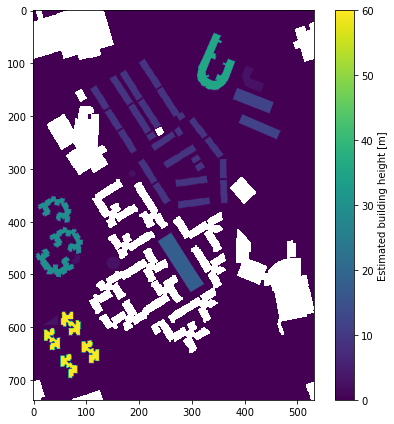

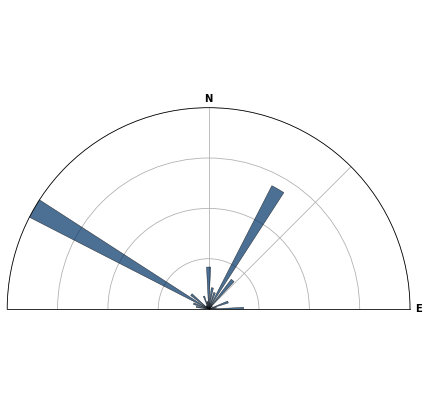

In [14]:
# Resolution on the x and y direction is set to equal.
resx = res
resy = res
bldH = np.nan
# Convert bbox to format that OSM can read and download the building footprint as geopandas dataframe
bbox,bbox_cor = select_region(cc)
# Download data from OSM with bbox as input
gdf = ox.geometries_from_bbox(bbox_cor[0],bbox_cor[1],bbox_cor[2],bbox_cor[3], {"building": True})
gdf.reset_index(level=0, inplace=True)
# Extract the geometry and building level
geo = gdf['geometry'].values
bHeight = gdf['building:levels'].values

# Calculate the centriod of each urban structure
# If centriod of one structure falls in the selected polygon, include it in the domain
centroid = []
for idxP in range(geo.shape[0]):
    centroid.append(geo[idxP].centroid)
data = {'geometry':geo,'cent':centroid}
# reproduce the dataframe with centeriod
gdf = pd.DataFrame(data)
x_mul,y_mul = projection(bbox_cor,resx,resy)

domain,gdf,x_start,y_start = initialize(bbox,gdf,x_mul,y_mul,bbox_cor)


lineO = [] # edge orientation
lineL = [] # edge length
area = [] # total area
areaH = [] # area with realistic building height


for idxP in range(gdf.shape[0]):# if centriod of the structure fall within the bbox
    if Point(gdf['cent'][idxP][0][0],gdf['cent'][idxP][1][0]).within(Polygon(bbox)):
        
        domain = process_building(domain,idxP,gdf,bHeight,x_mul,y_mul,x_start,y_start,bbox_cor,bldH)

x,y = cal_entropy(lineO,lineL)

print_domain(domain) 
phi = print_entropy(x,y) 
print_results(phi,domain,area,areaH,bldH)
